# Locality Exploration 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import itertools

from src.autoks.core.active_set import ActiveSet
from src.autoks.core.gp_model import GPModel
from src.autoks.core.grammar import BomsGrammar
from src.autoks.core.kernel_encoding import hd_kern_nodes
from src.autoks.distance.distance import HellingerDistanceBuilder
from src.evalg.fitness import structural_hamming_dist

%matplotlib inline
from GPy.core.parameterization.priors import Gaussian
from GPy.models import GPRegression
from scipy.stats.stats import pearsonr, spearmanr
import numpy as np
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

In [4]:
def create_hellinger_db(active_models, data_X):
    """Create Hellinger distance builder with all active models being candidates"""
    lik_noise_std = np.log(0.01)
    lik_noise_mean = 1
    noise_prior = Gaussian(lik_noise_std, lik_noise_mean)

    initial_model_indices = active_models.get_candidate_indices()

    num_samples = 20
    max_num_hyperparameters = 40
    max_num_kernels = 1000

    builder = HellingerDistanceBuilder(noise_prior, num_samples, max_num_hyperparameters, max_num_kernels,
                                       active_models, initial_model_indices, data_X=data_X)

    return builder

In [5]:
num_points = 100
num_dimensions = 2
data_x = np.random.randn(num_points, num_dimensions)

w = np.random.randn(num_dimensions, 1)
y = data_x @ w

In [6]:
base_kernel_names = ['SE', 'RQ']

In [7]:
grammar = BomsGrammar(base_kernel_names)
grammar.build(num_dimensions)

In [8]:
se_1, se_2, rq_1, rq_2 = grammar.base_kernels

In [9]:
starting_cov = se_1
neighbors = grammar.expand_single_kernel(starting_cov)
neighbors_2 = []
for n in neighbors:
    for nn in grammar.expand_single_kernel(n):
        neighbors_2.append(nn)

In [10]:
neighbors_0_1_2 = grammar.base_kernels + neighbors + neighbors_2

In [11]:
random_kernels = grammar.expand_random(100)

In [12]:
all_kernels = random_kernels

In [13]:
all_kernels[0]

Covariance(kernel='SE_1(variance=1.000000, lengthscale=1.000000) * RQ_2(variance=1.000000, lengthscale=1.000000, power=2.000000)')

In [14]:
# Optionally, convert kernels to canonical form
# for n in all_kernels:
#     n.raw_kernel = n.canonical()

In [15]:
def covariance_shd(cov_1, cov_2):
    tree_1 = cov_1.to_binary_tree()
    tree_2 = cov_2.to_binary_tree()

    return structural_hamming_dist(tree_1, tree_2, hd=hd_kern_nodes)

In [16]:
shd_dists = []
for cov_1, cov_2 in list(itertools.combinations(all_kernels, 2)):
    shd_dists.append(covariance_shd(cov_1, cov_2))
shd_dists = np.array(shd_dists)

Create Active Set

In [17]:
active_set = ActiveSet(1000)

In [18]:
models = [GPModel(cov) for cov in all_kernels]

In [19]:
all_candidate_ind = active_set.update(models)
len(all_candidate_ind)

100

In [20]:
distance_builder = create_hellinger_db(active_set, data_x)

In [21]:
distance_builder.compute_distance(active_set, all_candidate_ind, all_candidate_ind)

In [22]:
hellinger_K = distance_builder.get_kernel(len(all_candidate_ind))

In [23]:
pearsonr(shd_dists, squareform(hellinger_K))

(0.33212990217589894, 8.89055065977964e-128)

In [24]:
spearmanr(shd_dists, squareform(hellinger_K))

SpearmanrResult(correlation=0.1710216299894165, pvalue=8.399750652106028e-34)

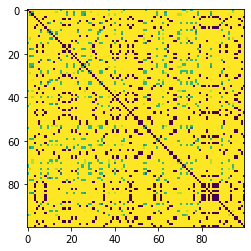

In [25]:
plt.imshow(squareform(shd_dists))

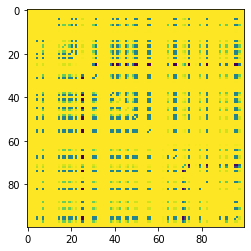

In [26]:
plt.imshow((hellinger_K - hellinger_K.mean()) / hellinger_K.std())

In [27]:
r = np.random.randn(shd_dists.shape[0])

In [28]:
spearmanr(shd_dists, r)

SpearmanrResult(correlation=-0.008057701383725545, pvalue=0.5708666719895736)

In [29]:
spearmanr(r, squareform(hellinger_K))

SpearmanrResult(correlation=-0.006466733993818281, pvalue=0.6492064251625673)

In [30]:
norm = (shd_dists - shd_dists.mean()) / shd_dists.std()

In [31]:
a = squareform(hellinger_K)
a = (a - a.mean()) / a.std()

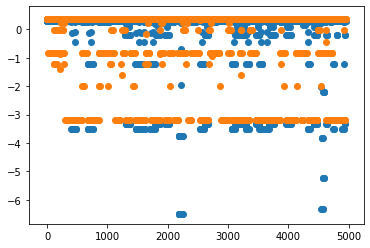

In [32]:
plt.scatter(np.arange(shd_dists.shape[0]), a)
plt.scatter(np.arange(shd_dists.shape[0]), norm)

### Now, investigate fitness value correlation (TODO)

In [33]:
def fitness_val(model):
    gp_reg = GPRegression(data_x, y, kernel=model.covariance.raw_kernel)
    gp_reg.optimize()
    return gp_reg.log_likelihood()

In [34]:
fitness_values = [fitness_val(model) for model in models]

 C:\Users\lousc\Anaconda3\envs\test-env-3-6\lib\site-packages\GPy\core\gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 2. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel
